<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

# BUILDING FLOOR RECOGNITION

Inspired by https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb

# Table of Contents

>[BUILDING FLOOR RECOGNITION](#scrollTo=SsIKuyArEu5c)

>[Table of Contents](#scrollTo=4sAfyFF7dWGm)

>[setup](#scrollTo=nogA7rji8GbZ)

>[utils](#scrollTo=1o3-BVUy8-sF)

>[Data](#scrollTo=pk-sYaYF7U9Y)

>>[Fetch cleaned dataset](#scrollTo=ALAyxPryCqFZ)

>>[sample audio](#scrollTo=w9GlJyvB2SoK)

>>[Modalities experimentations](#scrollTo=t46qlhPe2vHq)

>>>[Raw](#scrollTo=9ZMbXtvfG7Sa)

>>>[Spectrogram](#scrollTo=BAQnayGxG9vz)

>>>[MFCC](#scrollTo=b5Vm59MxHBYF)

>[Preprocessing & Packaging](#scrollTo=vg4POlOg2W6W)

>>[Waveform](#scrollTo=4jVjfEH_58rV)

>>[Spectrogram](#scrollTo=sHgonxaM55bk)

>>[MFCC](#scrollTo=zgxrq6hy512E)

>>[Spectrogram Image](#scrollTo=zHJDrkAhh522)

>>[Splitting Scheme](#scrollTo=9fs5X3NsPoZC)

>[Models](#scrollTo=PqSY1g2A2Yop)

>>[Pretrained](#scrollTo=mgXcolX4i9wc)

>>[SimpleNet](#scrollTo=2VMz6UQNvOzu)

>>[M5](#scrollTo=VBk4K9jdvRnQ)

>>[2d-CNN](#scrollTo=2bE-6QvuyNRH)

>[Training](#scrollTo=-b6VY1rH4Yrq)

>>[utils](#scrollTo=C47C65anl7y7)

>>[Dataset creation & Training & Evaluation](#scrollTo=tJxMkoJA-Jt-)

>>[Final Model](#scrollTo=i3H0iI0tshqr)

>>[Raw audio](#scrollTo=AgU0S5cWgpi9)

>[Results](#scrollTo=DsWDErTBXs3L)



In [1]:
# https://stats.stackexchange.com/questions/559009/why-convert-spectrogram-to-rgb-for-machine-learning

same buildings recording shall not be distributed between train and test sets


Remember:

* Train with more data
* Data Augmentation
* adding noise to the input and ouput data
* feature selection
* cross-validation
* simplify data
* regularization
* ensembling
* early stopping
* adding dropout layers


# setup

In [2]:
!nvidia-smi

Thu Jul 21 12:58:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.autograd import Variable
from torch import nn

print(torch.__version__)
print(torchaudio.__version__)

1.12.0+cu113
0.12.0+cu113


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import random 
import os
from copy import deepcopy

In [6]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
from IPython.display import Audio, display
from typing import Dict,Any

In [8]:
import librosa


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [9]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
from sklearn.metrics import classification_report

In [11]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        torchaudio.utils.sox_utils.set_seed(SEED_VAL)
        torch.manual_seed(SEED_VAL)
        torch.cuda.manual_seed_all(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [12]:
seed_all(496)

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [14]:
from torch.utils.data import Dataset

In [15]:
from torchvision import datasets, models, transforms


In [16]:
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 35.1 MB/s 
     |████████████████████████████████| 153 kB 68.3 MB/s 
     |████████████████████████████████| 181 kB 74.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2744ec9316d95141d49b09f492f9ed8d605e47392d7472e4596643250c8bf85a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [19]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [20]:
# show current directory
!pwd

/content


# utils

In [21]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)


def estimate_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  print('Approximated model size: {:.3f}MB'.format(size_all_mb))

In [22]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [23]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [24]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [25]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [26]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [27]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


# Data 

## Fetch cleaned dataset

In [28]:
!rm -r Data/
!rm building_floor_recognition_chunked.csv

rm: cannot remove 'Data/': No such file or directory
rm: cannot remove 'building_floor_recognition_chunked.csv': No such file or directory


In [29]:
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data_chunked.zip
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/building_floor_recognition_chunked.csv
!unzip -o -qqq Data_chunked.zip 
!rm Data_chunked.zip

--2022-07-21 12:59:35--  https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data_chunked.zip
Resolving huggingface.co (huggingface.co)... 35.174.43.234, 34.231.117.252, 50.17.131.86, ...
Connecting to huggingface.co (huggingface.co)|35.174.43.234|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/64396398bdc5702df504c2ce625617274158e70fdf1ede30a3c122645cf4802c?response-content-disposition=attachment%3B%20filename%3D%22Data_chunked.zip%22 [following]
--2022-07-21 12:59:35--  https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/64396398bdc5702df504c2ce625617274158e70fdf1ede30a3c122645cf4802c?response-content-disposition=attachment%3B%20filename%3D%22Data_chunked.zip%22
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 52.85.132.50, 52.85.132.4, 52.85.132.1

In [30]:
raw_dataset = pd.read_csv("building_floor_recognition_chunked.csv")
dataset = raw_dataset.copy()
dataset.floor.replace({1:0,3:1,5:2},inplace=True)
dataset.head(10)

,samples,floor,building
0,R+1/CB04_2/Esquissons_CB04_2.wav_2.wav,0,CB04
1,R+1/CB01_1/Esquissons_CB01-1.wav_4.wav,0,CB01
2,R+5/TIS06/Esquissons_TIS06.wav_1.wav,2,TIS06
3,R+1/VM06_1/Esquissons_VM06_1.wav_1.wav,0,VM06
4,R+5/FV12/Esquissons_FV12_2 wave.wav_4.wav,2,FV12
5,R+3/EC07A_2/Esquissons_EC07A_2.wav_4.wav,1,EC07A
6,R+1/EC07-B/Esquissons_EC07B.wav_3.wav,0,EC07-B
7,R+1/HS04/Esquissons_HS04.wav_4.wav,0,HS04
8,R+5/CB02/Esquissons_CB02S01 wave.wav_1.wav,2,CB02
9,R+1/VM02_1/Esquissons_VM02_1.wav_3.wav,0,VM02


In [31]:
raw_dataset.building.sample(2).values

array(['TIS06', 'EC07-B'], dtype=object)

In [32]:
#raw_dataset[raw_dataset.building.isin(raw_dataset.building.sample(2).values)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


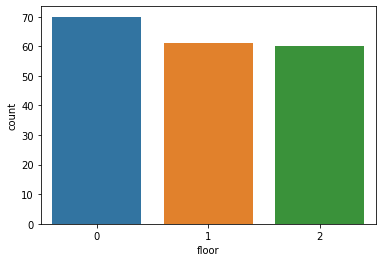

In [33]:

sns.countplot(dataset.floor)

In [34]:
dataset.shape

(191, 3)

## sample audio

In [35]:
# sample wav for testing purposes
sampled = raw_dataset.sample(1)
SAMPLE_WAV_PATH=os.path.join("/content","Data",sampled.samples.values[0])

In [36]:
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=220500, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [37]:
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")
print_stats(waveform,sample_rate)

Sample Rate: 44100
Shape: (1, 220500)
Dtype: torch.float32
 - Max:      0.060
 - Min:     -0.072
 - Mean:    -0.000
 - Std Dev:  0.015

tensor([[0.0039, 0.0058, 0.0041,  ..., 0.0032, 0.0059, 0.0100]])



In [38]:
play_audio(waveform,sample_rate)
print("Etage ",sampled.floor.values[0])

Etage  5


Text(0.5, 1.0, 'Linear-frequency power spectrogram')

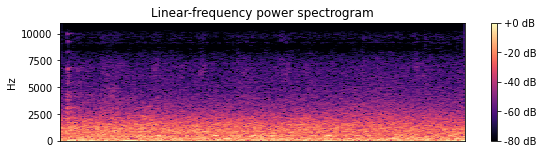

In [39]:
import librosa.display

dat2, sampling_rate2 = librosa.load(os.path.join("/content/Data",sampled.samples.values[0]))
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [40]:
D.shape

(1025, 216)

In [41]:

# path=os.path.join("/content","Data","R+1","CB01_2","Esquissons_CB01_2.wav")
# waveform,sample_rate = torchaudio.load(path,format="wav")
# play_audio(waveform,sample_rate)

## Modalities experimentations

### Raw

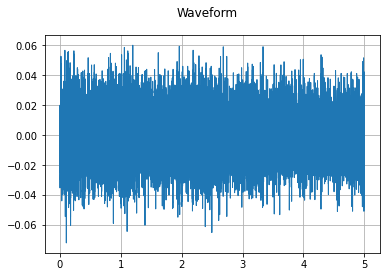

In [42]:
# plot raw waveform

plot_waveform(waveform,sample_rate=sample_rate)

In [43]:
waveform.shape

torch.Size([1, 220500])

In [44]:
random.uniform(0.85,1.15)

1.0689991808581503

In [45]:
random.choice([1.1,1.2])

1.2

In [46]:

effects = [
    ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
    ["speed", str(random.choice([0.85,0.9,0.95,1.15,1.05]))],  # reduce the speed
    # This only changes sample rate, so it is necessary to
    # add `rate` effect with original sample rate after this.
    ['gain', '-n', str(random.choice([-10,-5,0,5,10]))],  # apply 10 db attenuation

    ["rate", f"{sample_rate}"],
    ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects)


In [47]:
play_audio(waveform2,sample_rate2)

### Spectrogram

Shape: (1, 513, 431)
Dtype: torch.float32
 - Max:     54.927
 - Min:      0.000
 - Mean:     0.092
 - Std Dev:  0.752

tensor([[[8.8324e+00, 4.3491e-02, 1.6414e+00,  ..., 5.1911e-02,
          1.1248e+00, 1.2926e-01],
         [6.1557e-01, 1.4727e+01, 4.1471e+00,  ..., 7.5995e+00,
          1.6703e+01, 2.0588e+01],
         [3.1133e-01, 6.2569e+00, 5.5624e+00,  ..., 1.4731e+01,
          2.3111e+01, 2.5262e+01],
         ...,
         [1.6949e-04, 2.8321e-07, 6.7294e-06,  ..., 3.7438e-05,
          3.5649e-05, 8.9067e-05],
         [3.4888e-05, 1.6946e-10, 3.0640e-05,  ..., 3.3025e-06,
          4.5096e-05, 2.9194e-05],
         [8.3741e-06, 7.5859e-06, 6.3707e-05,  ..., 2.9501e-09,
          6.6923e-05, 9.6373e-06]]])



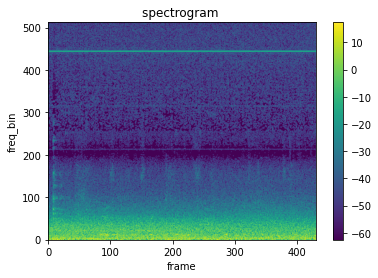

In [48]:
n_fft = 1024
win_length = 1024
hop_length = None

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=False,
)

# define transformation
spectrogram_norm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True,
)
# Perform transformation
spec1 = spectrogram(waveform)
# Perform transformation
spec2 = spectrogram_norm(waveform)


print_stats(spec1)
#print_stats(spec2)
plot_spectrogram(spec1[0], title='spectrogram ')
#plot_spectrogram(spec2[0], title='spectrogram normalized')

In [49]:
spec2[0].max()

tensor(0.1430)

In [50]:
spec1[0].max()

tensor(54.9274)

### MFCC

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape: (1, 256, 431)
Dtype: torch.float32
 - Max:     251.178
 - Min:     -321.774
 - Mean:    -3.905
 - Std Dev: 24.566

tensor([[[-3.1505e+02, -2.9577e+02, -3.0537e+02,  ..., -3.0401e+02,
          -3.0178e+02, -2.8317e+02],
         [ 2.0444e+02,  2.3572e+02,  2.3513e+02,  ...,  2.2612e+02,
           2.3068e+02,  2.2546e+02],
         [ 3.0121e+01,  4.2333e+01,  3.7275e+01,  ...,  4.6933e+01,
           5.2375e+01,  5.0844e+01],
         ...,
         [ 1.3580e+00,  1.4053e+00, -1.9564e+00,  ...,  2.8180e-02,
          -3.9221e+00, -2.5624e+00],
         [-1.7812e-01,  5.7683e-01, -2.6925e-01,  ...,  3.1538e-01,
          -1.9309e+00, -1.4098e+00],
         [ 8.9007e-01,  5.8582e-01, -1.1287e+00,  ...,  2.7751e+00,
           1.8790e+00,  1.8634e+00]]])



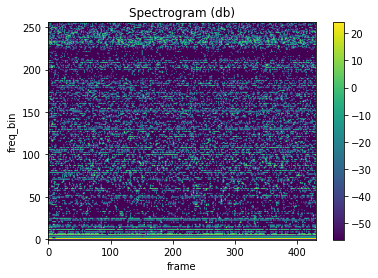

In [51]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)
print_stats(mfcc)
plot_spectrogram(mfcc[0])

In [52]:
from torchaudio.transforms import MFCC

In [53]:
def clean_mfcc(data):
  pass

def clean_spectrogram(data):
  pass

# Preprocessing & Packaging

check 
* https://jonathanbgn.com/2021/08/30/audio-augmentation.html
* https://developers.deepgram.com/blog/2022/06/pytorch-intro-with-torchaudio/

## Waveform

In [54]:
class SoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList,transform = False):
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        self.transform = transform
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i,1] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i,1])
                #self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
         #self.mixer = torchaudio.transforms.DownmixMono() 
        self.folderList = folderList
        
    def __getitem__(self, index):
        #format the file path and load the file
        path = self.file_path + self.file_names[index]
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)
        sound ,sample_rate = torchaudio.load(path, normalize = True)
        #print(sound.shape)
        # apply some effects : https://pytorch.org/tutorials//beginner/audio_data_augmentation_tutorial.html
        # if self.transform:
        #   effects = [
        #       #["lowpass", "-1", "300"],  # apply single-pole lowpass filter
        #       ["speed", str(random.choice([0.95,1,1.05]))],  # reduce the speed
        #       # This only changes sample rate, so it is necessary to
        #       # add `rate` effect with original sample rate after this.
        #       ['gain', '-n', str(random.choice([-5,-2.5,0,2.5,5]))],  # apply 10 db attenuation

        #       ["rate", f"{sample_rate}"],
        #       #["reverb", "-w"],  # Reverbration gives some dramatic feeling
        #   ]
        #   # # Apply effects
        #   sound, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(sound, sample_rate, effects)
        #   #print(sound.shape)
        #   sound = torch.mean(sound, dim=0).unsqueeze(0) # #UrbanSound8K uses two channels, this will convert them to one
        soundData = sound
        #print(soundData.shape,soundData.numel())
        #downsample the audio to ~8kHz
        # 120000
        tempData = torch.zeros([200000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 200000:
            tempData[:soundData.numel()] = soundData[:].T
        else:
            tempData[:] = soundData[:,:200000].T
        
        soundData = tempData
        soundFormatted = torch.zeros([40000, 1])
        #chunk = random.randint(0,4)
        soundFormatted[:40000] = soundData[::5]#take every sixth sample of soundData
        #soundFormatted = soundFormatted[chunk*40000:(chunk+1)*40000] #take a random chunk
        soundFormatted = soundFormatted.permute(1, 0)

        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)


## Spectrogram

In [55]:
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# check also https://colab.research.google.com/github/enzokro/clck10/blob/master/_notebooks/2020-09-10-Normalizing-spectrograms-for-deep-learning.ipynb#scrollTo=VBD562J9i2AF
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  #spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled


def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - 1.15) / (27 + eps)
  #spec_min, spec_max = spec_norm.min(), spec_norm.max()
  #spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
  #spec_scaled = spec_scaled.astype(np.uint8)
  return spec_norm

In [56]:
class SpecSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_fft, normalized=False, win_length = None, center = True,transform = False, pad_mode = "reflect", power = 2.0,hop_length=None):
        super().__init__(csvData, file_path, folderList,transform)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._center = center
        self._pad_mode = pad_mode
        self._power = power
        self._normalized = normalized
        # define transformation
        spectrogram = T.Spectrogram(
          n_fft= self._n_fft,
          win_length=self._win_length,
          hop_length=self._hop_length,
          center=self._center,
          pad_mode=self._pad_mode,
          power=self._power,
          normalized=self._normalized,
        )
        self._spec_mixer = spectrogram
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      transformed = self._spec_mixer(soundFormatted)
      # apply transformation
      return transformed, labels

    
    def __len__(self):
        return len(self.file_names)

## MFCC

In [57]:
# NORMALIZE VALUES
class MFCCSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_mfcc, sample_rate, n_fft = None, n_mels = None, mel_scale = 'htk',hop_length=512):
        super().__init__(csvData, file_path, folderList)
        self._n_fft = n_fft
        #print("ok",win_length)
        #self._win_length = win_length
        self._hop_length = hop_length
        self._n_mels = n_mels
        self._n_mfcc = n_mfcc 
        self._sample_rate = sample_rate
        self._mel_scale = mel_scale
        mfcc_transform = T.MFCC(
            sample_rate= self._sample_rate,
            n_mfcc=self._n_mfcc,
            
            melkwargs={
              'n_fft': self._n_fft,
              'n_mels': self._n_mels,
              'hop_length': self._hop_length,
              'mel_scale': self._mel_scale,
              #'win_length':self._n_fft,
            },
        )

        self._mfcc_transform = mfcc_transform
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      # apply transformation
      return self._mfcc_transform(soundFormatted), labels

    
    def __len__(self):
        return len(self.file_names)

## Late fusion

In [58]:
# NORMALIZE VALUES
class ComposedDataset(MFCCSoundDataset,SpecSoundDataset):    
    def __init__(self, datasets):
        assert(len(datasets)>0),"You should provide at least one dataset"
        assert(len(datasets[0])>0),"Datasets must not be empty"
        assert(all(len(datasets[0])==len(d) for d in datasets)),"All datasets don't have same size"
        self.datasets = datasets

    def __getitem__(self, index):
      tmp = [dataset[index] for dataset in self.datasets]
      labels = tmp[0][1]
      return tuple([t[0] for t in tmp]),labels
    
    def __len__(self):
        return len(self.datasets[0])

## Splitting Scheme

In [59]:
os.chdir("/content/")

In [60]:
csv_path = './building_floor_recognition.csv'
file_path = './Data/'

In [61]:
X_train, X_test = train_test_split(dataset, test_size=0.2, stratify = dataset.floor)
X_train, X_val = train_test_split(X_train, test_size=0.2, stratify = X_train.floor)

In [62]:
print("All set size: " + str(len(dataset)))
print("Train set size: " + str(len(X_train)))
print("Val set size: " + str(len(X_val)))
print("Test set size: " + str(len(X_test)))


All set size: 191
Train set size: 121
Val set size: 31
Test set size: 39


In [63]:

# # configure MFCC settings 
# config_spec_args = {
#     'n_fft':512,
#     'n_mfcc':180,
#     'sample_rate':8000,
#     'n_mels':180,

# }

# train_set = MFCCSoundDataset(X_train, file_path, range(0,6), **config_spec_args)
# test_set = MFCCSoundDataset(X_test, file_path, [10], **config_spec_args)

# Models

## Pretrained

In [64]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


## SimpleNet

In [65]:
class SimpleNet(nn.Module):
    def __init__(self,in_channels=1,n_output=3,repr_size = 9012):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels = 128, kernel_size = 5, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size = 5, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

        
            nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv2d(32,16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            # nn.Conv2d(64,64, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            nn.MaxPool2d(2,2),

            # nn.Conv2d(64,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),

            # nn.Conv2d(128,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(repr_size,128),
            nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            nn.Linear(128,n_output),
            # nn.Softmax(),
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


In [66]:
class NotSimpleNet(nn.Module):
    def __init__(self,in_channels=1,n_output=3,repr_size = 512):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

        
            nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv2d(64,32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32,16, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16,16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(repr_size,128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,n_output),
            #nn.Softmax(),
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


In [67]:
class SimpleSimpleNet(nn.Module):
    def __init__(self,in_channels=1, n_output=3,repr_size = 1984):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels = 32, kernel_size = 8, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 16, kernel_size = 8, stride = 1, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.6),
            nn.ReLU(),
            nn.MaxPool2d(8,8),

        
            # nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(32),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            # nn.Conv2d(32,16, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(16),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
            
            # nn.Conv2d(64, 16, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(16),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            # nn.Conv2d(64,64, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
           # nn.MaxPool2d(8,8),

            # nn.Conv2d(64,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),

            # nn.Conv2d(128,32, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(repr_size,64),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64,n_output),
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


## M5

In [68]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


## 2d-CNN

In [69]:
# https://www.kaggle.com/code/mhiro2/simple-2d-cnn-classifier-with-pytorch/notebook
# It is nicknamed "bigone" below

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        import torch.nn.functional as F
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

In [70]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=128),
            nn.Dropout(0.2),
            ConvBlock(in_channels=128, out_channels=128),
            nn.Dropout(0.2),
            ConvBlock(in_channels=128, out_channels=256),
            nn.Dropout(0.2),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            #nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x

# Training & Evaluation

## utils

In [72]:
# Reporting strategies

class Reporter:
  """
    proxy used for any reporter ( wandb, tensorboard, etc)
  """
  def __init__(self):
    pass

  def log(self,data:Dict[str, Any]):
    raise NotImplementedError

  def stop(self):
    raise NotImplementedError
  def start(self,**kwargs):
    raise NotImplementedError

class WandbReporter(Reporter):
  """
    wand reporter with permanent storage and wandb dashboard
  """
  def __init__(self,wandb,**kwargs):
    super().__init__()
    self._wandb = wandb
    self._kwargs = kwargs
  
  def log(self,data:Dict[str, Any]):
    self._wandb.log(data)

  def stop(self):
    self._wandb.finish()

  def start(self,**kwargs):
    self._wandb.init(project="audio-classification",**self._kwargs)
    


class DummyReporter(Reporter):
  """
    quick reporter with non permanent storage
  """
  def __init__(self):
    self._data={}

  def log(self,data:Dict[str, Any]):
    for key in data.keys():
      if key in self._data:
        self._data[key].append(data[key])
      else:
        self._data[key]=[data[key]]

  def get(self,key):
    return self._data[key]

  def stop(self):
    pass

  def start(self,**kwargs):
    pass

In [73]:
# Function to save the model
def saveModel(model,loss,base_path,suffix):
    path = f"bestModel_{suffix}.pth"
    if base_path:
      path = os.path.join(base_path,path)

    torch.save(model.state_dict(), path)

    return path

In [74]:
# Function to test the model with the test dataset and print the accuracy for the test images
def evaluate(model,test_loader,loss_fn,device=torch.device("cpu")):
    model.eval()
    model.to(device)
    accuracy = 0.0
    total = 0.0
    correct_true = 0.0
    predicted_true = 0.0
    target_true = 0.0
    loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
          
            #print(outputs.data)
            loss += loss_fn(outputs, labels) * labels.size(0)
            
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            # print(predicted)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
    accuracy = (100 * accuracy / total)
    return (loss.item()/len(test_loader.sampler), accuracy)

In [75]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model,train_loader,optimizer,loss_fn,train_steps=1000,device=torch.device("cpu"),reporter = None):
    
    best_accuracy = 0.0
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    
    
    running_loss = 0.0
    running_acc = 0.0
    running_samples = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        
        model.train()
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))


        # predict classes using images from the training set
        outputs = model(images)
        # print(outputs.data)
        # print("labels=",labels)
        # compute the loss based on model output and real labels
        loss = loss_fn(outputs, labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        #loss = F.nll_loss(outputs.squeeze(), labels)
        
        # backpropagate the loss
        loss.backward()

        # # https://discuss.pytorch.org/t/how-to-check-for-vanishing-exploding-gradients/9019
        # for name, param in model.named_parameters():
        #  print(name, param.grad.norm())
        #adjust parameters based on the calculated gradients
        optimizer.step()

        # Let's print statistics for every 1,000 images
        running_loss += loss.item() * labels.size(0)    # extract the loss value
        running_samples += labels.size(0)
        # print(running_samples)
      #if i % (train_steps) == (train_steps-1):    
      # print every 1000 (twice per epoch) 
        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / running_samples))
        if reporter:
            reporter.log({'train_loss':running_loss / running_samples})
          # zero the loss
        #return running_loss

        

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_classification_stats(model,loader,device):
  y_pred = []
  y_true = []

  model.eval()
  model.to(device)
  # iterate over test data
  for inputs, labels in loader:
          inputs,labels = inputs.to(device),labels.to(device)
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('R+1', 'R+3', 'R+5')

  # Build confusion matrix
  #cf_matrix = confusion_matrix(y_true, y_pred)
  #df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
  #                    columns = [i for i in classes])
  #plt.figure(figsize = (12,7))
  #sn.heatmap(df_cm, annot=True)
  #plt.savefig('output.png')
  print(classification_report(y_true, y_pred, target_names=classes))
  #plt.title()
  #plt.plot()


In [77]:
def initialize_weights(m):
   # look at : https://androidkt.com/initialize-weight-bias-pytorch/
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [78]:
# # define a cross validation function
# def crossvalid(model=None,criterion=None,dataset=None,k_fold=5,device=torch.device("cpu"),num_epochs=1, train_steps=1,lr=3e-4):
    
#     train_score = pd.Series()
#     val_score = pd.Series()
    
#     total_size = len(dataset)
#     fraction = 1/k_fold
#     seg = int(total_size * fraction)
#     # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
#     # index: [trll,trlr],[vall,valr],[trrl,trrr]
#     for i in range(k_fold):
#         print(f"Fold {i+1} training")
#         trll = 0
#         trlr = i * seg
#         vall = trlr
#         valr = i * seg + seg
#         trrl = valr
#         trrr = total_size
        

#         print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
#                 % (trll,trlr,trrl,trrr,vall,valr))
 
#         train_left_indices = list(range(trll,trlr))
#         train_right_indices = list(range(trrl,trrr))
        
#         train_indices = train_left_indices + train_right_indices
#         val_indices = list(range(vall,valr))
        
#         train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
#         val_set = torch.utils.data.dataset.Subset(dataset,val_indices)


#         _train_loader = torch.utils.data.DataLoader(train_set, batch_size=5,shuffle=True)
#         _val_loader = torch.utils.data.DataLoader(val_set, batch_size=5,shuffle=True)
        
#         res_model = deepcopy(model)
#         _optimizer = torch.optim.Adam(res_model.parameters(), lr=lr)
#         train_acc = train(res_model,_train_loader,_optimizer,criterion,eval_loader=_val_loader,num_epochs = num_epochs, train_steps=train_steps,device=device)
#         train_score.at[i] = train_acc
#         val_acc = valid(res_model,_val_loader,criterion,device)
#         val_score.at[i] = val_acc
#         del res_model
    
#     return train_score,val_score

In [79]:
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

check out https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-Tuning-ResNet-18-for-Audio-Classification--VmlldzoyOTAyMzc

## Dataset Creation

In [125]:
DATA ={}

In [186]:

train_spectrogram = True
batch_size = 16
if train_spectrogram:
  # configure spectrogram settings 
  config_spec_args = {
      'n_fft':1024,
      'win_length':1024,
  }
  all_set = SpecSoundDataset(dataset, file_path, range(0,6),**config_spec_args)
  train_set = SpecSoundDataset(X_train, file_path, range(0,6),transform = False, **config_spec_args)
  val_set = SpecSoundDataset(X_val, file_path, range(0,6), **config_spec_args)
  test_set = SpecSoundDataset(X_test, file_path, range(0,6), **config_spec_args)
  n_classes = X_train.floor.nunique()
  print("All set size: " + str(len(all_set)))
  print("Train set size: " + str(len(train_set)))
  print("Val set size: " + str(len(val_set)))
  print("Test set size: " + str(len(test_set)))



  kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
  train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = True, **kwargs)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, **kwargs)
  DATA['spec']={}
  DATA['spec']['train_set']=train_set
  DATA['spec']['test_set']=test_set
  DATA['spec']['train_loader']=train_loader
  DATA['spec']['val_loader']=val_loader
  DATA['spec']['test_loader']=test_loader


All set size: 191
Train set size: 121
Val set size: 31
Test set size: 39


In [187]:

batch_size = 16
if train_spectrogram:
  # configure spectrogram settings 
  config_spec_args = {
      'n_fft':1024,
      'win_length':1024,
      'normalized':True,
  }
  all_set = SpecSoundDataset(dataset, file_path, range(0,6),**config_spec_args)
  train_set = SpecSoundDataset(X_train, file_path, range(0,6),transform = False, **config_spec_args)
  val_set = SpecSoundDataset(X_val, file_path, range(0,6), **config_spec_args)
  test_set = SpecSoundDataset(X_test, file_path, range(0,6), **config_spec_args)
  n_classes = X_train.floor.nunique()
  print("All set size: " + str(len(all_set)))
  print("Train set size: " + str(len(train_set)))
  print("Val set size: " + str(len(val_set)))
  print("Test set size: " + str(len(test_set)))



  kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
  train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = True, **kwargs)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, **kwargs)
  DATA['spec_norm']={}
  DATA['spec_norm']['test_set']=test_set
  DATA['spec_norm']['train_loader']=train_loader
  DATA['spec_norm']['val_loader']=val_loader
  DATA['spec_norm']['test_loader']=test_loader


All set size: 191
Train set size: 121
Val set size: 31
Test set size: 39


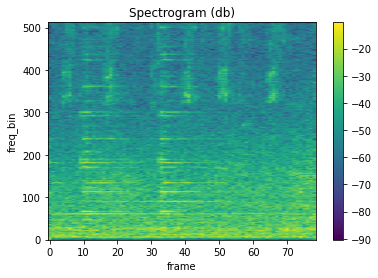

In [128]:
a = plot_spectrogram(val_set[8][0][0]) # first index 

In [188]:
train_mfcc = True
batch_size = 16
if train_mfcc:
  # configure spectrogram settings 
  config_mel_args={
                'n_fft':512,
              'n_mfcc': 1024,
              'n_mels': 1024,
              'sample_rate':8820,
              #'hop_length':512,
  }
  all_set = MFCCSoundDataset(dataset, file_path, range(0,6),**config_mel_args)
  train_set = MFCCSoundDataset(X_train, file_path, range(0,6), **config_mel_args)
  val_set = MFCCSoundDataset(X_val, file_path, range(0,6), **config_mel_args)
  test_set = MFCCSoundDataset(X_test, file_path, range(0,6), **config_mel_args)
  n_classes = X_train.floor.nunique()
  print("All set size: " + str(len(all_set)))
  print("Train set size: " + str(len(train_set)))
  print("Val set size: " + str(len(val_set)))
  print("Test set size: " + str(len(test_set)))



  kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu
  train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size , shuffle = True, **kwargs)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size , shuffle = True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, **kwargs)
  DATA['mfcc']={}
  DATA['mfcc']['test_set']=test_set
  DATA['mfcc']['train_set']=train_set
  DATA['mfcc']['train_loader']=train_loader
  DATA['mfcc']['val_loader']=val_loader
  DATA['mfcc']['test_loader']=test_loader


All set size: 191
Train set size: 121
Val set size: 31
Test set size: 39


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (1024) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


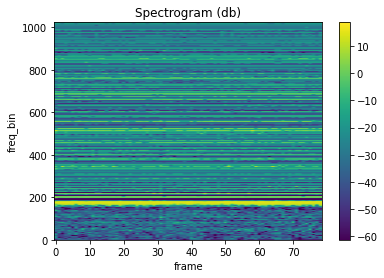

In [84]:
a = plot_spectrogram(val_set[8][0][0]) # first index 

In [85]:
val_set[8][0][0].shape

torch.Size([1024, 79])

## E2E : Training & Evaluation

In [86]:
!set CUDA_LAUNCH_BLOCKING=1
os.chdir("/content/")

In [87]:
MODELS = {
    'simplesimplenet':SimpleSimpleNet(in_channels=1,n_output=n_classes,repr_size=1984),
    'simplenet':SimpleNet(in_channels=1,n_output=n_classes,repr_size=9072),
    'notsimplenet':NotSimpleNet(in_channels=1,n_output=n_classes,repr_size=512),
    'simplesimplenetmfcc':SimpleSimpleNet(in_channels=1,n_output=n_classes,repr_size=4032),
    'simplenetmfcc':SimpleNet(in_channels=1,n_output=n_classes,repr_size=18288),
    'notsimplenetmfcc':NotSimpleNet(in_channels=1,n_output=n_classes,repr_size=1024),
    "bigone":Classifier(3),
}

In [88]:
test_model = NotSimpleNet(in_channels=1,n_output=n_classes,repr_size=512)
test_model(next(iter(DATA['spec_norm']['test_loader']))[0][0].unsqueeze(0))

tensor([[-0.2579,  0.0386, -0.0079]], grad_fn=<AddmmBackward0>)

In [89]:
next(iter(DATA['spec']['train_loader']))[0][0].unsqueeze(0).shape

torch.Size([1, 1, 513, 79])

In [98]:
MODELS_MODALITY ={
    "spec":{
        'bigone',
        'simplenet',
        'notsimplenet',
        'simplesimplenet',
    },
    "spec_norm":{
        'bigone',
        'simplenet',
        'notsimplenet',
        'simplesimplenet',
    },
    "mfcc":
    {
        'simplenetmfcc',
        'notsimplenetmfcc',
        'simplesimplenetmfcc'
    }
}

save_path = "/content/drive/MyDrive/consistency/audio-classification"

In [99]:
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [103]:
for modality in {'spec','spec_norm','mfcc'}:
  for model_name in MODELS_MODALITY[modality]:
    print(f"{bcolors.OKBLUE}Evaluating {model_name} on modality {modality}{bcolors.ENDC}")
    model = MODELS[model_name]
    if hasattr(model, '_init_weights'):
      model._init_weights()
    else:
      model.apply(initialize_weights) # Initilialize model weights
    rate_learning = 3e-3 #karapthy constant
    optimizer = torch.optim.Adam(model.parameters(), lr=rate_learning)
    loss_fn = nn.CrossEntropyLoss()
    patience = 3
    reduce_plateau_factor = 0.5
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience = patience, factor=reduce_plateau_factor, verbose=True)
    num_epochs = 40
    early_stop = 100
    chunk_size = 5
    reporter = WandbReporter(wandb,name=f"{model_name}-{modality}", config={"model":model_name, "epochs":num_epochs, "learning_rate":rate_learning, "batch_size":batch_size, "reduce_plateau_factor":0.5, "reduce_on_plateau_patience":batch_size, "chunked":chunk_size})
    
    # Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
  
    best_accuracy = 0.0
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    best_loss = 1e7
    count = 0

    if reporter:
      reporter.start()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        
        running_loss = train(model,DATA[modality]['train_loader'],optimizer,loss_fn,train_steps=1,device=device,reporter=reporter)
        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        train_loss, train_accuracy = evaluate(model,DATA[modality]['train_loader'],loss_fn,device)
        eval_loss, accuracy = evaluate(model,DATA[modality]['val_loader'],loss_fn,device)
        print('Epoch[', epoch+1,'] eval accuracy %d %%' % (accuracy),"eval loss %.3f" % (eval_loss))
        if reporter:
          reporter.log({'eval_loss':eval_loss,'eval_accuracy':accuracy})
          reporter.log({'train_loss_epoch':train_loss,'train_accuracy':train_accuracy})
        
        # we want to save the model if the accuracy is the best
        if best_loss > eval_loss:
            print("Saving best model so far model eval loss = ",eval_loss)
            saved_path = saveModel(model, eval_loss, base_path = save_path, suffix = f'{model_name}_{modality}')
            #model.save(os.path.join(wandb.run.dir, f"model_{model_name}_{modality}.h5"))
            best_loss = eval_loss
            count = 0 
        else:
          count += 1
        scheduler.step(eval_loss)
        
        if count>early_stop:
          print("Early Stopping loss did not improve for ",early_stop," epochs")
          break
    if reporter:
      reporter.stop()
      
    loaded_model = MODELS[model_name]
    loaded_model.load_state_dict(torch.load(saved_path))
    eval_train = evaluate(loaded_model,DATA[modality]['train_loader'],loss_fn,device)
    eval_eval = evaluate(loaded_model,DATA[modality]['val_loader'],loss_fn,device)
    eval_test = evaluate(loaded_model,DATA[modality]['test_loader'],loss_fn,device)
    print(f"{bcolors.OKGREEN}>> Results for {model_name} on modality {modality}{bcolors.ENDC}")
    print("Train :",eval_train,"Dev:",eval_eval,"Test",eval_test,end="\n\n",sep="\n")
    plot_classification_stats(loaded_model,DATA[modality]['test_loader'],device)

Evaluating bigone on modality spec


eval_accuracy,▂▂▅▁▄▂▂▇█▅▅▇▅▅▅▇▅▅▅▅▅▅▅▅▅▅▅▇▅▇▅▇▇▇▅▅▄▄▅▅
eval_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▃▃▂▁▂▂▁▅▄▄▇▆▇▄▅▇▇▆█▇▇▇▇▇▇▇▇▇▇▆▇▆▇▆▆▇██▆▆
train_loss,█▄▃▃▃▂▃▂▂▄▁▂▂▁▁▁▂▁▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▂▃▁▁▁▁
train_loss_epoch,█▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,51.6129
eval_loss,0.97114
train_accuracy,55.3719
train_loss,0.8571
train_loss_epoch,0.92358


[1,     1] loss: 1.547
[1,     2] loss: 1.320
[1,     3] loss: 1.257
[1,     4] loss: 1.213
[1,     5] loss: 1.174
[1,     6] loss: 1.169
[1,     7] loss: 1.240
[1,     8] loss: 1.242
Epoch[ 1 ] eval accuracy 38 % eval loss 1.025
Saving best model so far model eval loss =  1.025410621396957
[2,     1] loss: 1.046
[2,     2] loss: 0.973
[2,     3] loss: 0.973
[2,     4] loss: 1.062
[2,     5] loss: 1.049
[2,     6] loss: 1.081
[2,     7] loss: 1.087
[2,     8] loss: 1.082
Epoch[ 2 ] eval accuracy 38 % eval loss 1.067
[3,     1] loss: 0.990
[3,     2] loss: 1.008
[3,     3] loss: 1.016
[3,     4] loss: 1.002
[3,     5] loss: 0.993
[3,     6] loss: 0.976
[3,     7] loss: 0.988
[3,     8] loss: 0.999
Epoch[ 3 ] eval accuracy 51 % eval loss 0.974
Saving best model so far model eval loss =  0.9743160740021737
[4,     1] loss: 0.974
[4,     2] loss: 0.989
[4,     3] loss: 0.998
[4,     4] loss: 0.945
[4,     5] loss: 0.952
[4,     6] loss: 1.017
[4,     7] loss: 1.026
[4,     8] loss: 1.029
E

eval_accuracy,▁▁▅▃▃▅▄▅▅▄▄▅▅▄▅▆▆███▆▅▅▅▆▅▅▆▆▅▅▅▅▅▅▆▅▅▅▆
eval_loss,▆█▃▄▅▁▃▄▅▅▄▄▃▃▃▃▃▄▄▃▃▄▄▃▂▃▃▁▂▁▁▁▃▃▂▁▂▂▂▂
train_accuracy,▂▁▃▂▄▅▄▅▅▄▃▄▄▄▄▅▄▅▄▆▆▆▇▇█▇▇▇████▇▇██████
train_loss,█▆▅▄▅▄▆▄▄▄▅▅▄▅▄▄▄▃▃▃▄▄▄▄▃▂▂▄▃▄▂▃▄▃▃▂▂▁▂▂
train_loss_epoch,▇█▆▇▆▃▅▅▅▅▅▅▄▄▄▄▅▅▆▄▄▅▅▃▂▃▄▁▂▁▁▁▅▅▂▁▁▂▂▁
eval_accuracy,54.83871
eval_loss,0.9378
train_accuracy,57.85124
train_loss,0.83638
train_loss_epoch,0.90746


>> Results for bigone on modality spec
Train :
(0.9635257563315147, 49.586776859504134)
Dev:
(0.9274835894184728, 51.61290322580645)
Test
(1.0157661437988281, 51.282051282051285)

              precision    recall  f1-score   support

         R+1       0.80      0.57      0.67        14
         R+3       0.00      0.00      0.00        13
         R+5       0.41      1.00      0.59        12

    accuracy                           0.51        39
   macro avg       0.40      0.52      0.42        39
weighted avg       0.41      0.51      0.42        39

Evaluating simplesimplenet on modality spec


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1,     1] loss: 4.130
[1,     2] loss: 3.895
[1,     3] loss: 2.996
[1,     4] loss: 3.725
[1,     5] loss: 3.269
[1,     6] loss: 2.959
[1,     7] loss: 2.662
[1,     8] loss: 2.802
Epoch[ 1 ] eval accuracy 35 % eval loss 1.130
Saving best model so far model eval loss =  1.130252715080015
[2,     1] loss: 3.703
[2,     2] loss: 2.326
[2,     3] loss: 1.881
[2,     4] loss: 1.615
[2,     5] loss: 1.714
[2,     6] loss: 1.671
[2,     7] loss: 1.571
[2,     8] loss: 1.562
Epoch[ 2 ] eval accuracy 45 % eval loss 1.020
Saving best model so far model eval loss =  1.020084258048765
[3,     1] loss: 0.835
[3,     2] loss: 0.927
[3,     3] loss: 0.882
[3,     4] loss: 0.878
[3,     5] loss: 0.901
[3,     6] loss: 0.920
[3,     7] loss: 0.932
[3,     8] loss: 0.968
Epoch[ 3 ] eval accuracy 48 % eval loss 1.010
Saving best model so far model eval loss =  1.0104896791519657
[4,     1] loss: 0.830
[4,     2] loss: 0.888
[4,     3] loss: 0.883
[4,     4] loss: 0.977
[4,     5] loss: 0.981
[4,     

eval_accuracy,▁▄▅▄▂▂▅▅▅▇▄▅▃▅▅▅▃▆▄▄▄██▇▃▃▃▂▄▇▅▅▅▅▆▅▄▄▄▅
eval_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▂▃▃▃▂▂▂▂▂▃▃▃▃▃▃▂
train_accuracy,▁▃▄▄▄▃▃▄▄█▅▅▆█▆▅▅█▆▆▆██▇▆▆▅▆▇▇▇▇▇▇▇▇▆▆▇█
train_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▇▆▇██▇▇▆▆▅▄▄▅▄▄▃▂▃▄▃▂▁▁▂▃▄▃▃▂▂▂▂▂▁▁▃▂▂▁
eval_accuracy,51.6129
eval_loss,0.94757
train_accuracy,61.15702
train_loss,0.58029
train_loss_epoch,0.84668


>> Results for simplesimplenet on modality spec
Train :
(0.8562287259692988, 61.98347107438016)
Dev:
(0.9213616771082724, 61.29032258064516)
Test
(1.0454453688401442, 43.58974358974359)

              precision    recall  f1-score   support

         R+1       0.67      0.43      0.52        14
         R+3       0.37      0.54      0.44        13
         R+5       0.36      0.33      0.35        12

    accuracy                           0.44        39
   macro avg       0.47      0.43      0.44        39
weighted avg       0.47      0.44      0.44        39

Evaluating simplenet on modality spec


[1,     1] loss: 1.757
[1,     2] loss: 7.008
[1,     3] loss: 5.372
[1,     4] loss: 4.289
[1,     5] loss: 3.828
[1,     6] loss: 3.763
[1,     7] loss: 3.676
[1,     8] loss: 3.897
Epoch[ 1 ] eval accuracy 41 % eval loss 1.628
Saving best model so far model eval loss =  1.6284964776808215
[2,     1] loss: 1.270
[2,     2] loss: 1.576
[2,     3] loss: 1.412
[2,     4] loss: 1.499
[2,     5] loss: 1.396
[2,     6] loss: 1.567
[2,     7] loss: 1.652
[2,     8] loss: 1.620
Epoch[ 2 ] eval accuracy 48 % eval loss 0.986
Saving best model so far model eval loss =  0.9859566227082284
[3,     1] loss: 1.031
[3,     2] loss: 1.045
[3,     3] loss: 1.001
[3,     4] loss: 1.004
[3,     5] loss: 0.987
[3,     6] loss: 0.970
[3,     7] loss: 0.961
[3,     8] loss: 0.969
Epoch[ 3 ] eval accuracy 48 % eval loss 1.001
[4,     1] loss: 0.874
[4,     2] loss: 0.876
[4,     3] loss: 0.887
[4,     4] loss: 0.913
[4,     5] loss: 0.913
[4,     6] loss: 0.893
[4,     7] loss: 0.923
[4,     8] loss: 0.943


eval_accuracy,▁▃▃▃▂▇▇▆▆█▆▃▃▁▅▆▆▆▃▃▆▆▆▆▅▆▆▅▅▅▅▅▅▅▃▅▅▅▅▅
eval_loss,█▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▆▅▄▅▅▅▆▆▄▃▄▃▄▅▆▇▇▆█▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▆▇▇▇
train_loss,█▃▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,51.6129
eval_loss,0.94448
train_accuracy,54.54545
train_loss,0.69528
train_loss_epoch,0.9176


>> Results for simplenet on modality spec
Train :
(0.9181572149607761, 58.67768595041322)
Dev:
(0.9172720140026461, 54.83870967741935)
Test
(1.116106669108073, 48.717948717948715)

              precision    recall  f1-score   support

         R+1       0.80      0.57      0.67        14
         R+3       0.38      0.77      0.51        13
         R+5       0.33      0.08      0.13        12

    accuracy                           0.49        39
   macro avg       0.51      0.47      0.44        39
weighted avg       0.52      0.49      0.45        39

Evaluating notsimplenet on modality spec


[1,     1] loss: 1.188
[1,     2] loss: 1.170
[1,     3] loss: 1.144
[1,     4] loss: 1.647
[1,     5] loss: 1.572
[1,     6] loss: 1.497
[1,     7] loss: 1.386
[1,     8] loss: 1.351
Epoch[ 1 ] eval accuracy 41 % eval loss 2.965
Saving best model so far model eval loss =  2.964966312531502
[2,     1] loss: 0.901
[2,     2] loss: 0.937
[2,     3] loss: 1.054
[2,     4] loss: 1.007
[2,     5] loss: 1.279
[2,     6] loss: 1.243
[2,     7] loss: 1.268
[2,     8] loss: 1.246
Epoch[ 2 ] eval accuracy 48 % eval loss 1.202
Saving best model so far model eval loss =  1.2020726357736895
[3,     1] loss: 0.849
[3,     2] loss: 0.874
[3,     3] loss: 0.930
[3,     4] loss: 0.921
[3,     5] loss: 1.145
[3,     6] loss: 1.141
[3,     7] loss: 1.109
[3,     8] loss: 1.094
Epoch[ 3 ] eval accuracy 48 % eval loss 0.947
Saving best model so far model eval loss =  0.9474755564043599
[4,     1] loss: 0.989
[4,     2] loss: 0.980
[4,     3] loss: 0.982
[4,     4] loss: 0.947
[4,     5] loss: 0.952
[4,    

eval_accuracy,▁▄▄▄▂▁▄▄▄▂▇▅█▇▄▅▅▅▇▄▅▄▄▄▅▄▄▄▅▅▅▅▅▅▅▄▅▇█▅
eval_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▄▃▄▃▄▅▅▅▆▅▅▅▅▆▆▅▅▆▇▆▆▆▆▆▇▇▇█▆▆▇▆▆▇███▇
train_loss,█▄▃▃▃▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▂▁▂▂▁▁▂
train_loss_epoch,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,51.6129
eval_loss,0.96476
train_accuracy,59.50413
train_loss,0.69717
train_loss_epoch,0.81456


>> Results for notsimplenet on modality spec
Train :
(0.892415700865186, 53.71900826446281)
Dev:
(0.9238631956038936, 51.61290322580645)
Test
(1.1068514310396635, 48.717948717948715)

              precision    recall  f1-score   support

         R+1       0.58      0.50      0.54        14
         R+3       0.00      0.00      0.00        13
         R+5       0.44      1.00      0.62        12

    accuracy                           0.49        39
   macro avg       0.34      0.50      0.38        39
weighted avg       0.35      0.49      0.38        39

Evaluating bigone on modality spec_norm


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1,     1] loss: 1.422
[1,     2] loss: 1.411
[1,     3] loss: 1.256
[1,     4] loss: 1.185
[1,     5] loss: 1.162
[1,     6] loss: 1.265
[1,     7] loss: 1.277
[1,     8] loss: 1.255
Epoch[ 1 ] eval accuracy 32 % eval loss 1.106
Saving best model so far model eval loss =  1.1057603897586945
[2,     1] loss: 1.090
[2,     2] loss: 1.149
[2,     3] loss: 1.123
[2,     4] loss: 1.094
[2,     5] loss: 1.079
[2,     6] loss: 1.083
[2,     7] loss: 1.082
[2,     8] loss: 1.070
Epoch[ 2 ] eval accuracy 32 % eval loss 1.111
[3,     1] loss: 0.941
[3,     2] loss: 0.963
[3,     3] loss: 0.969
[3,     4] loss: 1.018
[3,     5] loss: 0.973
[3,     6] loss: 1.033
[3,     7] loss: 1.026
[3,     8] loss: 1.016
Epoch[ 3 ] eval accuracy 32 % eval loss 1.119
[4,     1] loss: 1.028
[4,     2] loss: 0.965
[4,     3] loss: 0.983
[4,     4] loss: 1.003
[4,     5] loss: 0.977
[4,     6] loss: 0.997
[4,     7] loss: 0.995
[4,     8] loss: 0.991
Epoch[ 4 ] eval accuracy 32 % eval loss 1.103
Saving best model

eval_accuracy,▁▁▁▁▁▁▂▂▂▂▁▄▄▄▅▅▆▆▆█▅▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅
eval_loss,▇▇▇▇██▇▇▇█▇▅▆▇█▁▁▂▄▅▃▃▃▃▂▂▂▁▂▄▄▄▂▂▁▂▁▃▂▂
train_accuracy,▁▁▁▁▁▁▂▂▂▂▂▂▅▅▂██▆▅▅▆▆▆██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_loss,█▆▅▅▅█▆▅▅▅▅▃▄▄▅▃▂▃▃▄▃▁▃▃▁▂▂▃▁▃▃▁▃▃▂▂▂▂▃▃
train_loss_epoch,▆▆▆▆▇▇▆▆▆▇▆▅▆▆█▁▁▃▆▅▃▂▃▁▁▂▁▂▂▄▃▃▁▁▁▁▁▂▂▂
eval_accuracy,54.83871
eval_loss,0.94316
train_accuracy,57.85124
train_loss,0.88102
train_loss_epoch,0.90236


>> Results for bigone on modality spec_norm
Train :
(0.8975746217838003, 58.67768595041322)
Dev:
(0.9022960047568044, 58.064516129032256)
Test
(1.1330745403583233, 38.46153846153846)

              precision    recall  f1-score   support

         R+1       0.75      0.43      0.55        14
         R+3       0.33      0.31      0.32        13
         R+5       0.26      0.42      0.32        12

    accuracy                           0.38        39
   macro avg       0.45      0.38      0.40        39
weighted avg       0.46      0.38      0.40        39

Evaluating simplesimplenet on modality spec_norm


[1,     1] loss: 1.364
[1,     2] loss: 1.651
[1,     3] loss: 1.410
[1,     4] loss: 1.978
[1,     5] loss: 3.342
[1,     6] loss: 3.261
[1,     7] loss: 3.024
[1,     8] loss: 2.929
Epoch[ 1 ] eval accuracy 32 % eval loss 1.147
Saving best model so far model eval loss =  1.1465838032384073
[2,     1] loss: 1.075
[2,     2] loss: 1.145
[2,     3] loss: 1.082
[2,     4] loss: 1.856
[2,     5] loss: 2.009
[2,     6] loss: 1.816
[2,     7] loss: 1.704
[2,     8] loss: 1.653
Epoch[ 2 ] eval accuracy 32 % eval loss 1.107
Saving best model so far model eval loss =  1.1068821568642893
[3,     1] loss: 1.088
[3,     2] loss: 1.025
[3,     3] loss: 0.988
[3,     4] loss: 0.952
[3,     5] loss: 0.973
[3,     6] loss: 0.990
[3,     7] loss: 0.957
[3,     8] loss: 0.970
Epoch[ 3 ] eval accuracy 32 % eval loss 1.121
[4,     1] loss: 1.140
[4,     2] loss: 1.079
[4,     3] loss: 1.145
[4,     4] loss: 1.146
[4,     5] loss: 1.135
[4,     6] loss: 1.082
[4,     7] loss: 1.051
[4,     8] loss: 1.031


eval_accuracy,▁▁▁▂▂▃▂▂▂▂▃▃▄▅▇█▆▆▄▆▇▇█▆▅▅▆▆▆▆▇▇▆▆██▅▇▅▅
eval_loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▂▂▂▂▃▃▃▂▂▃▂▂▂▁▁▂▂▁▁▁▂▂▂▂▁▁
train_accuracy,▁▁▁▂▂▁▂▂▂▃▃▃▄▄▇▇▇▇▆▇███▇▇▇▇▇▇▇██▇▇██▆▇▇▇
train_loss,█▇▃▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▂▁▂▂▂▁▂▁
train_loss_epoch,█▇▇▇▇▇▇▇▆▆▆▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁
eval_accuracy,48.3871
eval_loss,0.9191
train_accuracy,55.3719
train_loss,0.62397
train_loss_epoch,0.8401


>> Results for simplesimplenet on modality spec_norm
Train :
(0.8401023927798941, 55.37190082644628)
Dev:
(0.9191033147996471, 48.38709677419355)
Test
(1.2335103352864583, 38.46153846153846)

              precision    recall  f1-score   support

         R+1       0.62      0.36      0.45        14
         R+3       0.33      0.62      0.43        13
         R+5       0.29      0.17      0.21        12

    accuracy                           0.38        39
   macro avg       0.41      0.38      0.37        39
weighted avg       0.42      0.38      0.37        39

Evaluating simplenet on modality spec_norm


[1,     1] loss: 2.165
[1,     2] loss: 2.099
[1,     3] loss: 2.242
[1,     4] loss: 2.431
[1,     5] loss: 2.645
[1,     6] loss: 2.382
[1,     7] loss: 2.232
[1,     8] loss: 2.381
Epoch[ 1 ] eval accuracy 32 % eval loss 1.326
Saving best model so far model eval loss =  1.3259317951817666
[2,     1] loss: 0.897
[2,     2] loss: 1.209
[2,     3] loss: 1.362
[2,     4] loss: 1.435
[2,     5] loss: 1.318
[2,     6] loss: 1.307
[2,     7] loss: 1.674
[2,     8] loss: 1.957
Epoch[ 2 ] eval accuracy 32 % eval loss 1.102
Saving best model so far model eval loss =  1.1021268290858115
[3,     1] loss: 1.005
[3,     2] loss: 0.858
[3,     3] loss: 0.871
[3,     4] loss: 0.967
[3,     5] loss: 1.537
[3,     6] loss: 1.811
[3,     7] loss: 1.741
[3,     8] loss: 1.687
Epoch[ 3 ] eval accuracy 32 % eval loss 1.135
[4,     1] loss: 1.679
[4,     2] loss: 1.248
[4,     3] loss: 1.097
[4,     4] loss: 1.243
[4,     5] loss: 1.154
[4,     6] loss: 1.131
[4,     7] loss: 1.110
[4,     8] loss: 1.094


eval_accuracy,▁▁▁▁▂▁▁▁▃▄▄▃▂▄▄▄▄▆▆▆▆▅▄▅█▆▅▅▅▄▇▇▅▄▄▄▄▄▄▄
eval_loss,█▃▄▄▄▄▅▄▃▃▃▃▂▁▂▁▁▁▂▁▁▁▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▂▁▂
train_accuracy,▁▁▁▁▁▁▁▁▂▂▂▂▃▄▄▄▅▅▆▆▆▆▆▆█▇▇▆▆▇▇█▇▆▆▆▇▇▇▇
train_loss,█▄▃▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁
train_loss_epoch,█▅▅▅▅▆▆▅▅▅▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁
eval_accuracy,45.16129
eval_loss,1.03419
train_accuracy,59.50413
train_loss,0.64706
train_loss_epoch,0.82645


>> Results for simplenet on modality spec_norm
Train :
(0.8982833357881909, 51.239669421487605)
Dev:
(1.0019320211102885, 51.61290322580645)
Test
(1.1165266770582933, 48.717948717948715)

              precision    recall  f1-score   support

         R+1       0.88      0.50      0.64        14
         R+3       0.39      0.85      0.54        13
         R+5       0.33      0.08      0.13        12

    accuracy                           0.49        39
   macro avg       0.53      0.48      0.44        39
weighted avg       0.55      0.49      0.45        39

Evaluating notsimplenet on modality spec_norm


[1,     1] loss: 2.321
[1,     2] loss: 1.650
[1,     3] loss: 1.562
[1,     4] loss: 1.394
[1,     5] loss: 1.487
[1,     6] loss: 1.394
[1,     7] loss: 1.367
[1,     8] loss: 1.343
Epoch[ 1 ] eval accuracy 32 % eval loss 1.101
Saving best model so far model eval loss =  1.1007540302891885
[2,     1] loss: 1.094
[2,     2] loss: 1.002
[2,     3] loss: 0.990
[2,     4] loss: 1.007
[2,     5] loss: 1.005
[2,     6] loss: 1.027
[2,     7] loss: 1.052
[2,     8] loss: 1.111
Epoch[ 2 ] eval accuracy 32 % eval loss 1.101
[3,     1] loss: 1.029
[3,     2] loss: 0.987
[3,     3] loss: 1.218
[3,     4] loss: 1.320
[3,     5] loss: 1.234
[3,     6] loss: 1.194
[3,     7] loss: 1.166
[3,     8] loss: 1.144
Epoch[ 3 ] eval accuracy 32 % eval loss 1.107
[4,     1] loss: 0.976
[4,     2] loss: 1.057
[4,     3] loss: 1.008
[4,     4] loss: 0.999
[4,     5] loss: 1.018
[4,     6] loss: 0.998
[4,     7] loss: 0.992
[4,     8] loss: 0.983
Epoch[ 4 ] eval accuracy 32 % eval loss 1.105
[5,     1] loss: 

eval_accuracy,▁▁▁▁▂▁▂▂▂▃▃▃▅▅▆▆█▅▄▃█▆▆▇▇█▆▇▆▆▆▇▇▆▆▆▆▆▆▆
eval_loss,▇▇▇▇▇██▇▇▆▆▆▅▄▄▄▃▃▄▃▂▂▂▁▁▁▂▅▃▄▂▂▂▃▃▂▂▂▂▂
train_accuracy,▁▁▁▁▁▁▁▂▂▁▂▃▄▄▅▅▅▄▄▅▆▅▆▆▆▆▅▇▆▆▆▇▇▆▆▇▇███
train_loss,█▅▇▅▅▅▅▄▅▄▄▄▄▄▅▄▅▄▄▄▃▄▃▃▃▂▃▃▂▂▃▁▂▂▂▂▁▂▂▁
train_loss_epoch,▇▇█▇███▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▄▄▃▃▄▂▂▂▃▃▂▂▂▁▁
eval_accuracy,54.83871
eval_loss,0.90715
train_accuracy,74.38017
train_loss,0.42673
train_loss_epoch,0.6125


>> Results for notsimplenet on modality spec_norm
Train :
(0.7846927485190147, 61.15702479338843)
Dev:
(0.8457995383970199, 58.064516129032256)
Test
(1.4405955779246795, 46.15384615384615)

              precision    recall  f1-score   support

         R+1       0.67      0.57      0.62        14
         R+3       0.38      0.38      0.38        13
         R+5       0.36      0.42      0.38        12

    accuracy                           0.46        39
   macro avg       0.47      0.46      0.46        39
weighted avg       0.48      0.46      0.47        39

Evaluating simplenetmfcc on modality mfcc


[1,     1] loss: 1.322
[1,     2] loss: 47.609
[1,     3] loss: 44.332
[1,     4] loss: 38.468
[1,     5] loss: 32.047
[1,     6] loss: 27.080
[1,     7] loss: 23.842
[1,     8] loss: 22.434
Epoch[ 1 ] eval accuracy 32 % eval loss 68.765
Saving best model so far model eval loss =  68.7653572328629
[2,     1] loss: 3.071
[2,     2] loss: 2.703
[2,     3] loss: 2.301
[2,     4] loss: 2.706
[2,     5] loss: 2.771
[2,     6] loss: 2.454
[2,     7] loss: 2.376
[2,     8] loss: 2.388
Epoch[ 2 ] eval accuracy 32 % eval loss 15.433
Saving best model so far model eval loss =  15.433050340221774
[3,     1] loss: 2.142
[3,     2] loss: 2.182
[3,     3] loss: 2.069
[3,     4] loss: 1.902
[3,     5] loss: 1.769
[3,     6] loss: 1.665
[3,     7] loss: 1.591
[3,     8] loss: 1.590
Epoch[ 3 ] eval accuracy 38 % eval loss 1.201
Saving best model so far model eval loss =  1.2009815093009704
[4,     1] loss: 1.518
[4,     2] loss: 1.365
[4,     3] loss: 1.498
[4,     4] loss: 1.736
[4,     5] loss: 1.754

eval_accuracy,▁▁▄▂▅█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
eval_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▅▄▄█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,35.48387
eval_loss,1.60031
train_accuracy,37.19008
train_loss,0.96994
train_loss_epoch,1.48052


>> Results for simplenetmfcc on modality mfcc
Train :
(1.0017761987102918, 52.06611570247934)
Dev:
(1.0273568553309287, 48.38709677419355)
Test
(1.0301251533703926, 53.84615384615385)

              precision    recall  f1-score   support

         R+1       0.75      0.64      0.69        14
         R+3       1.00      0.08      0.14        13
         R+5       0.42      0.92      0.58        12

    accuracy                           0.54        39
   macro avg       0.72      0.55      0.47        39
weighted avg       0.73      0.54      0.47        39

Evaluating simplesimplenetmfcc on modality mfcc


[1,     1] loss: 9.187
[1,     2] loss: 19.364
[1,     3] loss: 23.015
[1,     4] loss: 21.501
[1,     5] loss: 22.981
[1,     6] loss: 21.727
[1,     7] loss: 19.665
[1,     8] loss: 18.580
Epoch[ 1 ] eval accuracy 29 % eval loss 3.966
Saving best model so far model eval loss =  3.9661717568674395
[2,     1] loss: 3.255
[2,     2] loss: 3.446
[2,     3] loss: 3.720
[2,     4] loss: 3.132
[2,     5] loss: 2.768
[2,     6] loss: 2.488
[2,     7] loss: 2.276
[2,     8] loss: 2.190
Epoch[ 2 ] eval accuracy 32 % eval loss 1.969
Saving best model so far model eval loss =  1.969114734280494
[3,     1] loss: 1.064
[3,     2] loss: 1.205
[3,     3] loss: 1.272
[3,     4] loss: 1.205
[3,     5] loss: 1.201
[3,     6] loss: 1.173
[3,     7] loss: 1.151
[3,     8] loss: 1.145
Epoch[ 3 ] eval accuracy 29 % eval loss 1.085
Saving best model so far model eval loss =  1.0850265256820186
[4,     1] loss: 1.097
[4,     2] loss: 1.024
[4,     3] loss: 1.028
[4,     4] loss: 1.044
[4,     5] loss: 1.065


eval_accuracy,▁▂▁▃▂▆▇▇▂▆▂▅▇██▄▇▄▇▇▃█▇▄██▅▆▄▇▇██▆▆▆▆▆▆▆
eval_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▂▃▄▆▆▇▆▆▇▆▇▇▇█▇█▇▇█▇▇█▇▇███▇▇█████▇▇▇▇
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,45.16129
eval_loss,1.02765
train_accuracy,47.93388
train_loss,0.97657
train_loss_epoch,0.99394


>> Results for simplesimplenetmfcc on modality mfcc
Train :
(0.9939409366323928, 47.93388429752066)
Dev:
(1.0276544017176474, 45.16129032258065)
Test
(1.0660799466646635, 43.58974358974359)

              precision    recall  f1-score   support

         R+1       0.50      0.57      0.53        14
         R+3       0.00      0.00      0.00        13
         R+5       0.39      0.75      0.51        12

    accuracy                           0.44        39
   macro avg       0.30      0.44      0.35        39
weighted avg       0.30      0.44      0.35        39

Evaluating notsimplenetmfcc on modality mfcc


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1,     1] loss: 2.896
[1,     2] loss: 2.414
[1,     3] loss: 2.518
[1,     4] loss: 2.226
[1,     5] loss: 2.114
[1,     6] loss: 2.085
[1,     7] loss: 1.984
[1,     8] loss: 1.908
Epoch[ 1 ] eval accuracy 32 % eval loss 12.629
Saving best model so far model eval loss =  12.629312822895665
[2,     1] loss: 1.572
[2,     2] loss: 1.619
[2,     3] loss: 1.492
[2,     4] loss: 1.466
[2,     5] loss: 1.414
[2,     6] loss: 1.363
[2,     7] loss: 1.327
[2,     8] loss: 1.312
Epoch[ 2 ] eval accuracy 35 % eval loss 1.275
Saving best model so far model eval loss =  1.2747589849656629
[3,     1] loss: 1.137
[3,     2] loss: 1.182
[3,     3] loss: 1.139
[3,     4] loss: 1.138
[3,     5] loss: 1.126
[3,     6] loss: 1.125
[3,     7] loss: 1.115
[3,     8] loss: 1.115
Epoch[ 3 ] eval accuracy 32 % eval loss 1.119
Saving best model so far model eval loss =  1.1192181494928175
[4,     1] loss: 1.088
[4,     2] loss: 1.079
[4,     3] loss: 1.089
[4,     4] loss: 1.084
[4,     5] loss: 1.079
[4,  

eval_accuracy,▁▂▁▅▃▄▅▄▆▆▇▅▇▆▅▅▅▃▅▆▅▆▅▆█▇▆▇▆▆▇▆▆▆▆▆▆▆▇▆
eval_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▁▅▃▃▅▄▄▆▆▅▇▆▅▆▄▆▆▄▆▆▇▆▇▆▇▆▆▆██▇▇▇▇▇▇█▇
train_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁
train_loss_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_accuracy,48.3871
eval_loss,1.04131
train_accuracy,52.89256
train_loss,0.90977
train_loss_epoch,0.90398


>> Results for notsimplenetmfcc on modality mfcc
Train :
(0.9757482985819667, 42.14876033057851)
Dev:
(0.9809167923465851, 48.38709677419355)
Test
(1.1365453279935396, 41.02564102564103)

              precision    recall  f1-score   support

         R+1       0.55      0.43      0.48        14
         R+3       0.37      0.77      0.50        13
         R+5       0.00      0.00      0.00        12

    accuracy                           0.41        39
   macro avg       0.31      0.40      0.33        39
weighted avg       0.32      0.41      0.34        39



In [93]:
# from torch_lr_finder import LRFinder
# lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")

In [94]:
# train_score,val_score = crossvalid(net,loss_fn,dataset=all_set,device = device, k_fold=5, num_epochs = 20)

In [95]:
# lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="exp")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

##  Late Fusion: Training & Evaluation

In [205]:
train_set_mfcc = DATA['mfcc']['train_set']
train_set_spec = DATA['spec']['train_set']
train_set= ComposedDataset([train_set_spec,train_set_mfcc])
combined_loader = torch.utils.data.DataLoader(train_set, batch_size = 1 , shuffle = True)

test_set_mfcc = DATA['mfcc']['test_set']
test_set_spec = DATA['spec']['test_set']
test_set= ComposedDataset([test_set_spec,test_set_mfcc])
combined_loader_test = torch.utils.data.DataLoader(test_set, batch_size = 1 , shuffle = True)

In [157]:
model_name = "simplenet"
modality = "spec"
s = MODELS[model_name]
s.load_state_dict(torch.load(os.path.join(save_path,f'bestModel_{model_name}_{modality}.pth')))


model_name = "simplenetmfcc"
modality = "mfcc"
smfcc = MODELS[model_name]
smfcc.load_state_dict(torch.load(os.path.join(save_path,f'bestModel_{model_name}_{modality}.pth')))


<All keys matched successfully>

In [251]:
def transform_to_logits(dataset,model):
  res = []
  labels = []
  model.to(device)
  model.eval()
  for images,l in dataset:
    images = images.to(device)
    res.append(model(images.unsqueeze(0)))
    labels.append(l.item())
  return torch.stack(res).cpu().numpy().squeeze(1),labels

In [252]:
def combine_sets(datasets,models):
  assert(len(datasets)==len(models))
  res = []
  for i,(dataset,model) in enumerate(zip(datasets,models)):
    X,y = transform_to_logits(dataset,model)
    res.append(X)
    if i>0:
      assert(y==tmp)
    tmp = y
  return np.concatenate(res,axis = 1),y

In [262]:
models = [s, smfcc]
datasets = [train_set_spec, train_set_mfcc]
datasets_test = [test_set_spec, test_set_mfcc]

X,y = combine_sets(datasets, models)
X_test,y_test = combine_sets(datasets_test, models)

In [258]:
X.shape,len(y)

((121, 6), 121)

In [269]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=3, random_state=0)

In [270]:
clf.score(X,y)

0.7355371900826446

In [271]:
clf.score(X_test,y_test)

0.48717948717948717

## Early Fusion : Training & Evaluation

# Results